# 11. Camera calibration and RGBD 2 Point Cloud reconstruction
* https://vision.in.tum.de/data/datasets/rgbd-dataset/download
* https://docs.opencv.org/master/dc/dbb/tutorial_py_calibration.html
.

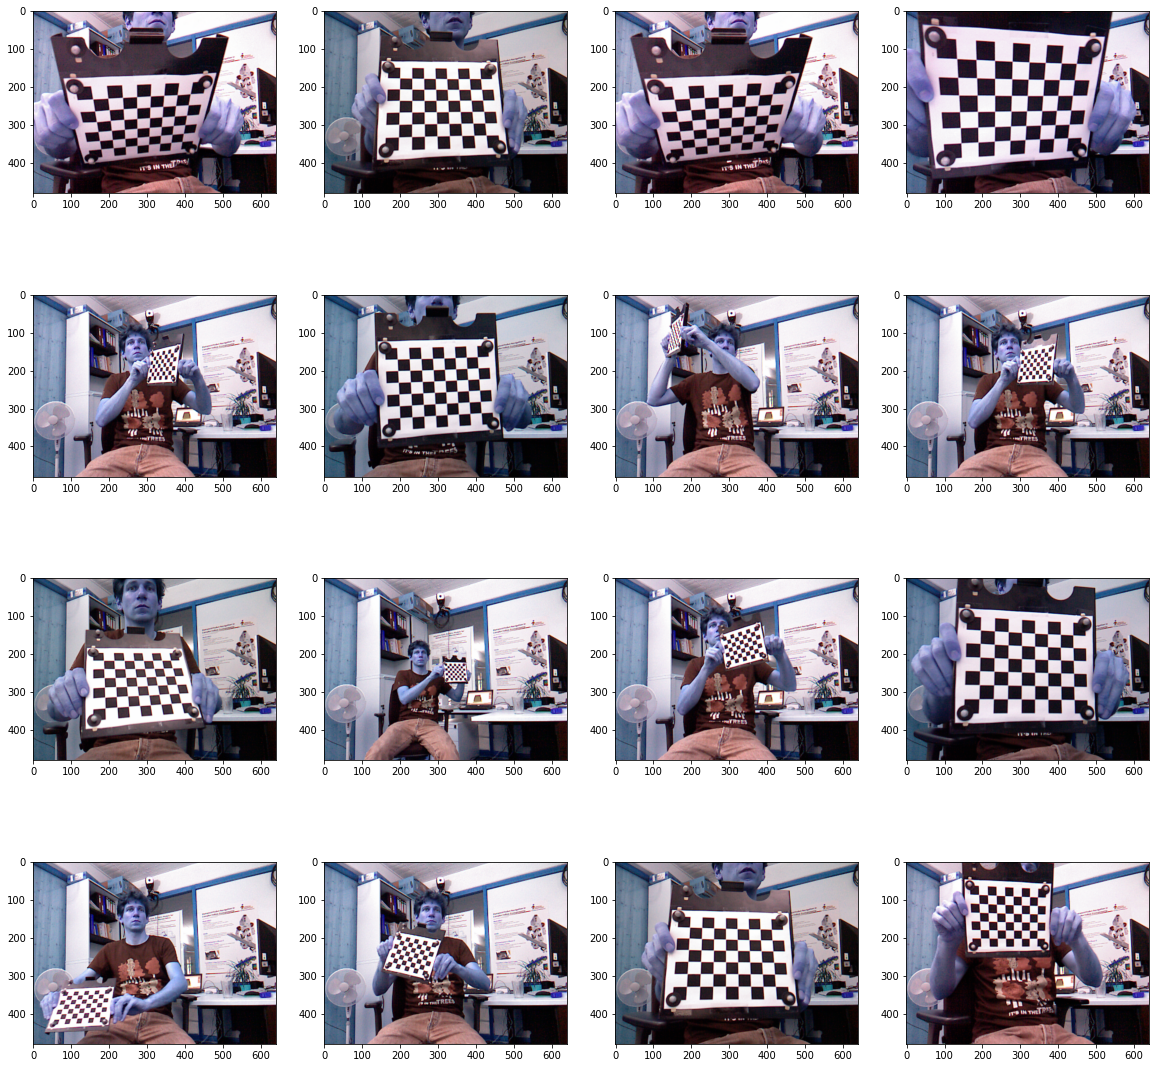

In [26]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import cv2 as cv
from tqdm.notebook import tqdm

filepaths = np.array(glob("/home/miro/Downloads/rgbd_dataset_freiburg1_rgb_calibration/rgb/*.png"))
idx = np.random.randint(0,len(filepaths),250)
sub_filepaths = filepaths[idx]

fig, axs = plt.subplots(4, 4,figsize=(20,20))

for i, fp in zip(range(16),sub_filepaths):
    img = cv.imread(fp)
    axs[i//4,i%4].imshow(img)

In [27]:
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 0.0001)

objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)
objpoints = list()
imgpoints = list()
for fp in tqdm(sub_filepaths):
    img = cv.imread(fp)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (7,6), None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners)
        # Draw and display the corners
        #cv.drawChessboardCorners(img, (7,6), corners2, ret)
        #cv.imshow('img', img)
        #cv.waitKey(500)

#cv.destroyAllWindows()

  0%|          | 0/250 [00:00<?, ?it/s]

* https://vision.in.tum.de/data/datasets/rgbd-dataset/file_formats#intrinsic_camera_calibration_of_the_kinect

In [28]:
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
print("Camera instrisic matrix:\n",mtx)
print("Camea distortion coefficient\n",dist)

Camera instrisic matrix:
 [[558.73307376   0.         305.62140712]
 [  0.         554.02256253 262.09340256]
 [  0.           0.           1.        ]]
Camea distortion coefficient
 [[ 3.96818251e-01 -2.31648760e+00 -2.19758175e-03 -5.52881888e-03
   4.66639489e+00]]


In [29]:
mean_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv.norm(imgpoints[i], imgpoints2, cv.NORM_L2)/len(imgpoints2)
    mean_error += error
print( "total error: {}".format(mean_error/len(objpoints)) )

total error: 0.5542652569318457


* The depth images are scaled by a factor of 5000, i.e., a pixel value of 5000 in the depth image corresponds to a distance of 1 meter from the camera, 10000 to 2 meter distance, etc. A pixel value of 0 means missing value/no data.

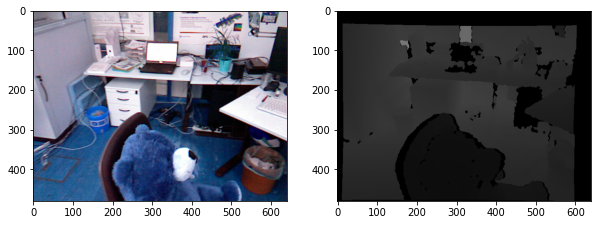

In [33]:
teddy_rgb = glob("/home/miro/Downloads/fr1/rgbd_dataset_freiburg1_teddy/rgb/*.png")
teddy_rgb= sorted(teddy_rgb)
teddy_depth = glob("/home/miro/Downloads/fr1/rgbd_dataset_freiburg1_teddy/depth/*.png")
teddy_depth = sorted(teddy_depth)
idx =250
img = cv.imread(teddy_rgb[idx])
depth_image = cv.imread(teddy_depth[idx])
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(depth_image)

In [34]:
factor=5000
fx = mtx[0,0]
fy = mtx[1,1]
cx = mtx[0,2]
cy = mtx[1,2]
X,Y,Z,R,G,B = list(),list(),list(),list(),list(),list()
for v in range(depth_image.shape[0]):
  for u in range(depth_image.shape[1]):
    z = depth_image[v,u,0] / factor
    Z.append(z)
    X.append((u - cx) * z / fx)
    Y.append((v - cy) * z / fy)
    R.append(img[v,u,0])
    G.append(img[v,u,1])
    B.append(img[v,u,2])

In [35]:
import open3d as o3d

cloud = o3d.geometry.PointCloud()
pts =np.array((X,Y,Z)).T
colors = np.array((R,G,B)).T/255
cloud.points = o3d.utility.Vector3dVector(pts)
cloud.colors = o3d.utility.Vector3dVector(colors)

o3d.visualization.draw_geometries([cloud])
